## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Check imports

In [38]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=1850)

In [39]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [40]:
test_eq(TEST,'test1')

AssertionError: ==:
test
test1

In [ ]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

## Get data

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2159)

In [41]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [42]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/Users/dpanchal/.fastai/data/mnist.pkl.gz')

In [43]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1') # standard serialization format in python is pickle. MNIST is stored in this format and gives us tuples of tuples

In [44]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid)) # since we are not going to use numpy, we are going to convert it to tensors. so we have 4 tensors now from the 4 numpy arrays
n,c = x_train.shape # n - # of rows, c - # of columns
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()
# 50000 rows, 784 cols, the y data is the array 5,0,4,...
# range of dependent varialbe is 0 to 9

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [45]:
assert n==y_train.shape[0]==50000 # test for number of rows
test_eq(c,28*28) # MNIST pixels are 28 x 28
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [46]:
mpl.rcParams['image.cmap'] = 'gray'

In [47]:
img = x_train[0]

In [48]:
img.view(28,28).type()

'torch.FloatTensor'

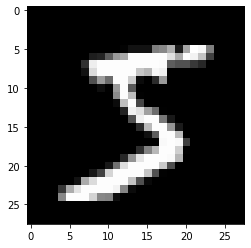

In [49]:
plt.imshow(img.view((28,28)));

## Initial python model

 [Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2342)

 [Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2342)

In [50]:
weights = torch.randn(784,10) # For a linear mode y=ax+b where a = bunch of weights i.e. 784 inputs, 10 outputs. 10 is something we took at random

In [51]:
bias = torch.zeros(10)

#### Matrix multiplication

In [52]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br # This is required since we need to do matrix multiplication
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [53]:
m1 = x_valid[:5]
m2 = weights # weight matrix

In [58]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [59]:
%time t1=matmul(m1, m2)

CPU times: user 1.02 s, sys: 15.5 ms, total: 1.04 s
Wall time: 1.13 s


In [60]:
t1.shape

torch.Size([5, 10])

This is kinda slow - what if we could speed it up by 50,000 times? Let's try!

In [61]:
len(x_train)

50000

#### Elementwise ops
We do this because the above took about 1 sec to complete the operation for 5 rows. if we try to do this for 50000, it will take a lot more time. This is because python is slow. hence, we tend to dedicate this task to PyTorch. PyTorch behind the scenes uses something like A10, which is faster

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

 [Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2682)

In [62]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [63]:
a + b

tensor([12., 14.,  3.])

In [64]:
(a < b).float().mean()

tensor(0.6667)

In [65]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m # This is a rank 2 tensor or a matrix

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

The above equation occurs in Deep Learning literatute quite a lot. So whenever you see ||A|| subscript F, it means Forbenius norm.

In [66]:
(m*m).sum().sqrt() # This is replacing the 3rd 'k' for loop in our 3 loop nested equation on the top with Python

tensor(16.8819)

#### Elementwise matmul

In [67]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum() # This is running in C under the hood
    return c

In [68]:
%timeit -n 10 _=matmul(m1, m2) # this is 178% faster than the native python code we saw above

1.55 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
890.1/5

178.02

In [70]:
#export
# this is to compare times 't1' i.e. python based approach and time for matmul(a,b) i.e. tensor based approach with some degree of threshold.
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [71]:
test_near(t1,matmul(m1, m2))

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=3110)

#### Broadcasting with a scalar

In [72]:
a

tensor([10.,  6., -4.])

In [73]:
a > 0

tensor([ True,  True, False])

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [74]:
a + 1

tensor([11.,  7., -3.])

In [75]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [76]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [84]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [85]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [86]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [87]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [88]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [89]:
t = c.expand_as(m) # this would give the actual detail of the broadcast operation as it in the vectorization mode which is inherently how the compiler does it. thus making it run in C

In [90]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [91]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Given how the data is vectorized to make it run faster, it must be taking lots of memory. So let's check that. 
But actually, that's not true. Looking inside the memory in python shows the pytorch is only storing 1 copy of the data


In [92]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [93]:
t.stride(), t.shape # t.shape: knows that it is supposed to be a 3 x 3 matrix, #t.stride: determines that it needs to take 1 step COLUMNWISE and 0 steps ROW-WISE to proceed with the computation

((0, 1), torch.Size([3, 3]))

<p>From the above, using broadcasting, we can achieve C like speed + saving memory by using these tensor operations</p>
-------

<h3>You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [94]:
c

tensor([10., 20., 30.])

In [95]:
c.unsqueeze(0) # view how another dimension is added, by presence of that extract square bracket giving it the shape of (1,3)

tensor([[10., 20., 30.]])

In [96]:
c.unsqueeze(1) #This adds an additional dim of size 1 at position 1. Visualize that an external square bracket is added around each element, giving it the shape of (3,1)

tensor([[10.],
        [20.],
        [30.]])

In [97]:
c.unsqueeze(-1)

tensor([[10.],
        [20.],
        [30.]])

In [104]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [99]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [100]:
c.shape, c[None,:].shape,c[:,None].shape # this operation is same as the above. If more dims need to be added, can always do c[None,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [101]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [102]:
c[:,None].expand_as(m) # This is getting broadcasted along columns instead of rows to take the shape of 'm'

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [105]:
c[None,:].expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [111]:
m + c[:,None] # This is getting broadcasted along the rows and added with 'm'
# OR m + c.unsqueeze(1)

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [112]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

#### Matmul with broadcasting

In [238]:
(m[0].unsqueeze(-1)*m)

tensor([[ 1.,  2.,  3.],
        [ 8., 10., 12.],
        [21., 24., 27.]])

In [239]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc) # initialize output vector in the correct dims
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0) # you can write: c[i,:] as  c[i]
    return c

The above loop works like this:
![image info](vscode-resource:/Users/dpanchal/Downloads/matmul.png)






In [244]:
# same tensors multiplied as in the image above
matmul(tensor([[1,3],[2,4]]),tensor([[5,6],[7,8]]))

tensor([[26., 30.],
        [38., 44.]])

In [245]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 4.54 times longer than the fastest. This could mean that an intermediate result is being cached.
379 µs ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [246]:
885000/277

3194.945848375451

In [ ]:
test_near(t1, matmul(m1, m2))

#### Broadcasting Rules

In [ ]:
c[None,:]

tensor([[10., 20., 30.]])

In [ ]:
c[None,:].shape

torch.Size([1, 3])

In [ ]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [ ]:
c[:,None].shape

torch.Size([3, 1])

In [ ]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [ ]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=4280)

In [ ]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [ ]:
%timeit -n 10 _=matmul(m1, m2)

57.2 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
885000/55

16090.90909090909

In [ ]:
test_near(t1, matmul(m1, m2))

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=4702)

In [247]:
%timeit -n 10 t2 = m1.matmul(m2) # this is the fastest because internally, pytorch dividies the entire matrix space into smaller matrices and then does the computation on those individual matrices making it super fast. this is something that companies like NVIDIA, Intel work on to develop eg. https://developer.nvidia.com/cudnn

The slowest run took 20025.74 times longer than the fastest. This could mean that an intermediate result is being cached.
23.1 ms ± 56.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [248]:
# time comparison vs pure python:
885000/18

49166.666666666664

In [249]:
t2 = m1@m2 # another way to matrix multiplication 

In [250]:
test_near(t1, t2)

In [251]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

<h1> This is where we complete the first step of MATMUL. The next will be RELU/Init </h1>

## Export

In [ ]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to nb_01.py
